# Predicting Diabetes Risk with Linear SVM

This notebook demonstrates how a linear SVM can be used to predict diabetes status using demographic and lifestyle factors from the NHIS 2022 dataset. We address class imbalance, engineer features, and interpret the results using key visualizations.


In [ ]:
# Cell 1: Data Preparation and Feature Engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Load cleaned data
df = pd.read_csv('../data/nhis_2022_cleaned.csv')

# Select features and target
features = ['AGE', 'BMICALC', 'HRSLEEP', 'CIGDAYMO']
target = 'DIABETICEV'

# Recode target: 1.0 = No Diabetes, 2.0 = Diabetes -> 0 = No, 1 = Yes
df[target] = df[target].replace({1.0: 0, 2.0: 1})

# Drop rows with missing values
df = df.dropna(subset=features + [target])

# Add BMI × Age interaction feature
df['BMI_AGE_INTERACTION'] = df['BMICALC'] * df['AGE']
features_with_interaction = features + ['BMI_AGE_INTERACTION']

X = df[features_with_interaction]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42, sampling_strategy=0.75)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)


## Model Training and Evaluation

We use grid search to tune the linear SVM, optimizing for F1-score due to class imbalance. The best model is then evaluated on the test set.


In [ ]:
# Cell 2: Model Training
param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_linear = GridSearchCV(
    SVC(kernel='linear', probability=True, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

svm_linear.fit(X_train_res, y_train_res)
print("Best parameters:", svm_linear.best_params_)

y_pred = svm_linear.predict(X_test_scaled)
y_prob = svm_linear.predict_proba(X_test_scaled)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)


Best parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 2}}
Test Accuracy: 0.6458333333333334

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.63      0.76       174
         1.0       0.18      0.78      0.29        18

    accuracy                           0.65       192
   macro avg       0.57      0.70      0.53       192
weighted avg       0.89      0.65      0.72       192

[[110  64]
 [  4  14]]


## Confusion Matrix

The confusion matrix below summarizes the model's predictions on the test set. The model correctly identified 14 out of 18 diabetes cases (bottom right), but also produced 64 false positives (top right). This tradeoff is common in screening models, where catching as many true cases as possible is often prioritized over minimizing false alarms.


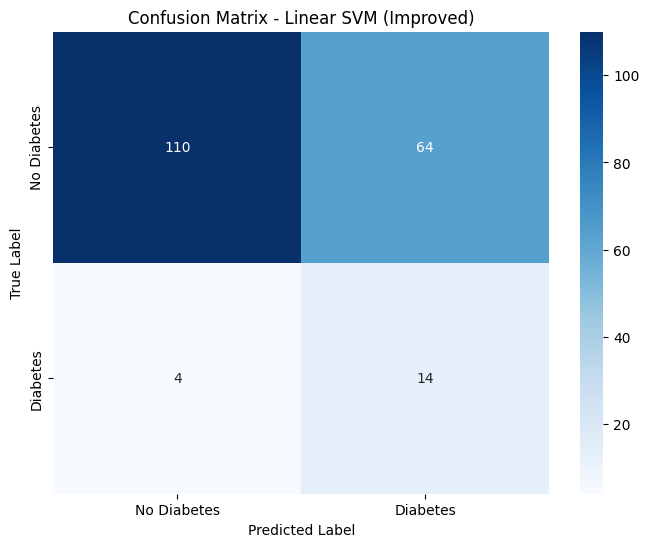

In [ ]:
# Cell 3: Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix - Linear SVM (Improved)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("../results/linear_confusion_matrix.png")
plt.show()


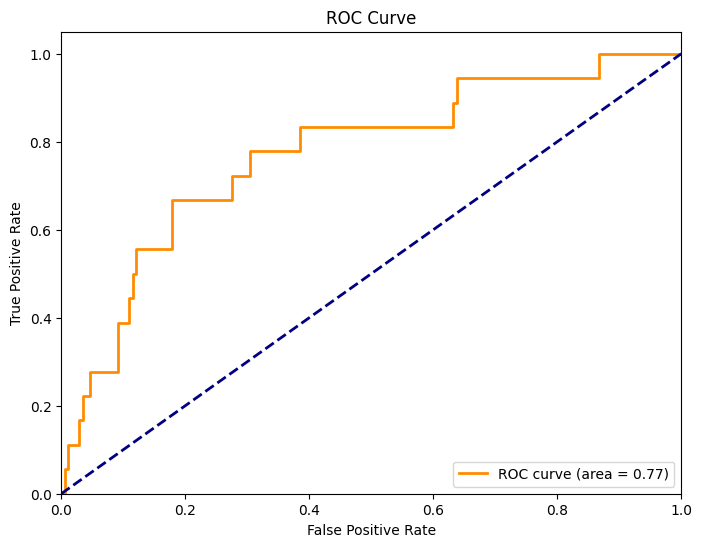

In [ ]:
# Cell 4: ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("../results/linear_roc.png")
plt.show()


## ROC Curve

This ROC curve shows the tradeoff between sensitivity (true positive rate) and specificity (1 - false positive rate) for the linear SVM model. The area under the curve (AUC) is 0.77, indicating good discrimination between diabetes and non-diabetes cases. The model performs well above random guessing (the dashed diagonal line).


## SVM Decision Boundary with BMI and Age




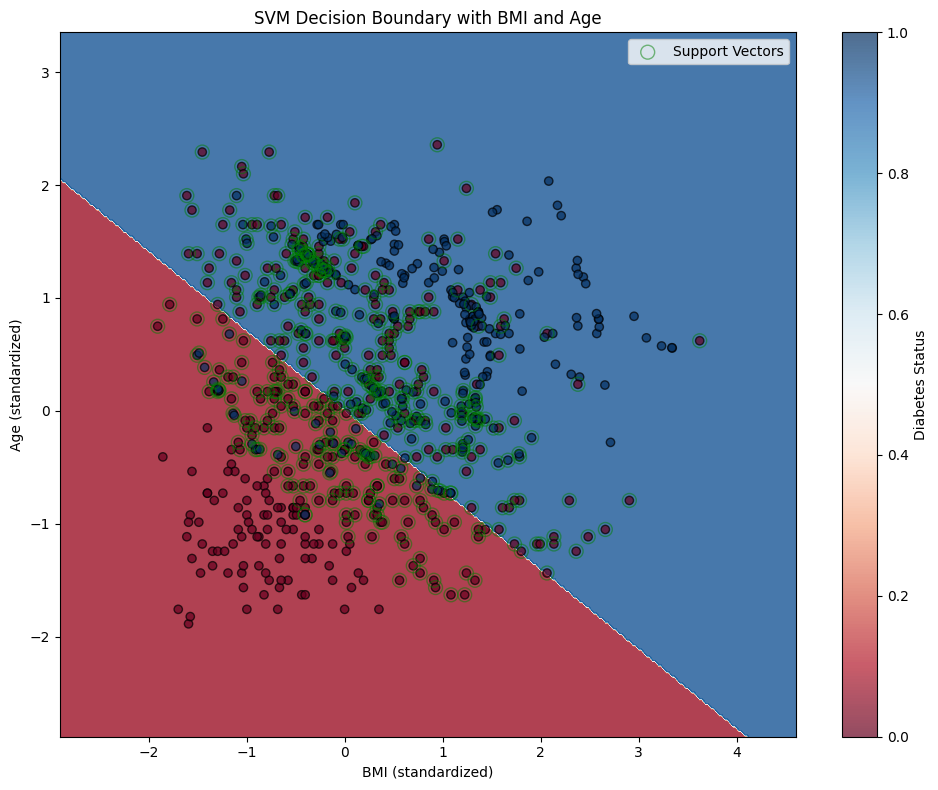

In [ ]:
# Cell 5: Decision Boundary Plot
idx_bmi = features_with_interaction.index('BMICALC')
idx_age = features_with_interaction.index('AGE')
X_vis = X_train_res[:, [idx_bmi, idx_age]]

svm_viz = SVC(kernel='linear', C=svm_linear.best_params_['C'], 
              class_weight=svm_linear.best_params_['class_weight'], probability=True)
svm_viz.fit(X_vis, y_train_res)

# Create mesh grid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svm_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='RdBu')
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train_res, edgecolors='k', cmap='RdBu', alpha=0.7)
plt.xlabel('BMI (standardized)')
plt.ylabel('Age (standardized)')
plt.title('SVM Decision Boundary with BMI and Age')
plt.colorbar(scatter, label='Diabetes Status')
sv_indices = svm_viz.support_
plt.scatter(X_vis[sv_indices, 0], X_vis[sv_indices, 1], s=100, linewidth=1, facecolors='none', edgecolors='green', alpha=0.5, label='Support Vectors')
plt.legend()
plt.tight_layout()
plt.savefig("../results/linear_svm.png")
plt.show()


The plot shows the decision boundary learned by the linear SVM using standardized BMI and Age as predictors. Each point represents an individual in the resampled training set, colored by diabetes status. The green-circled points are the support vectors that define the margin. The boundary is diagonal, indicating that both higher BMI and higher age increase diabetes risk—consistent with clinical knowledge. There is some overlap, but the separation is clear and interpretable.

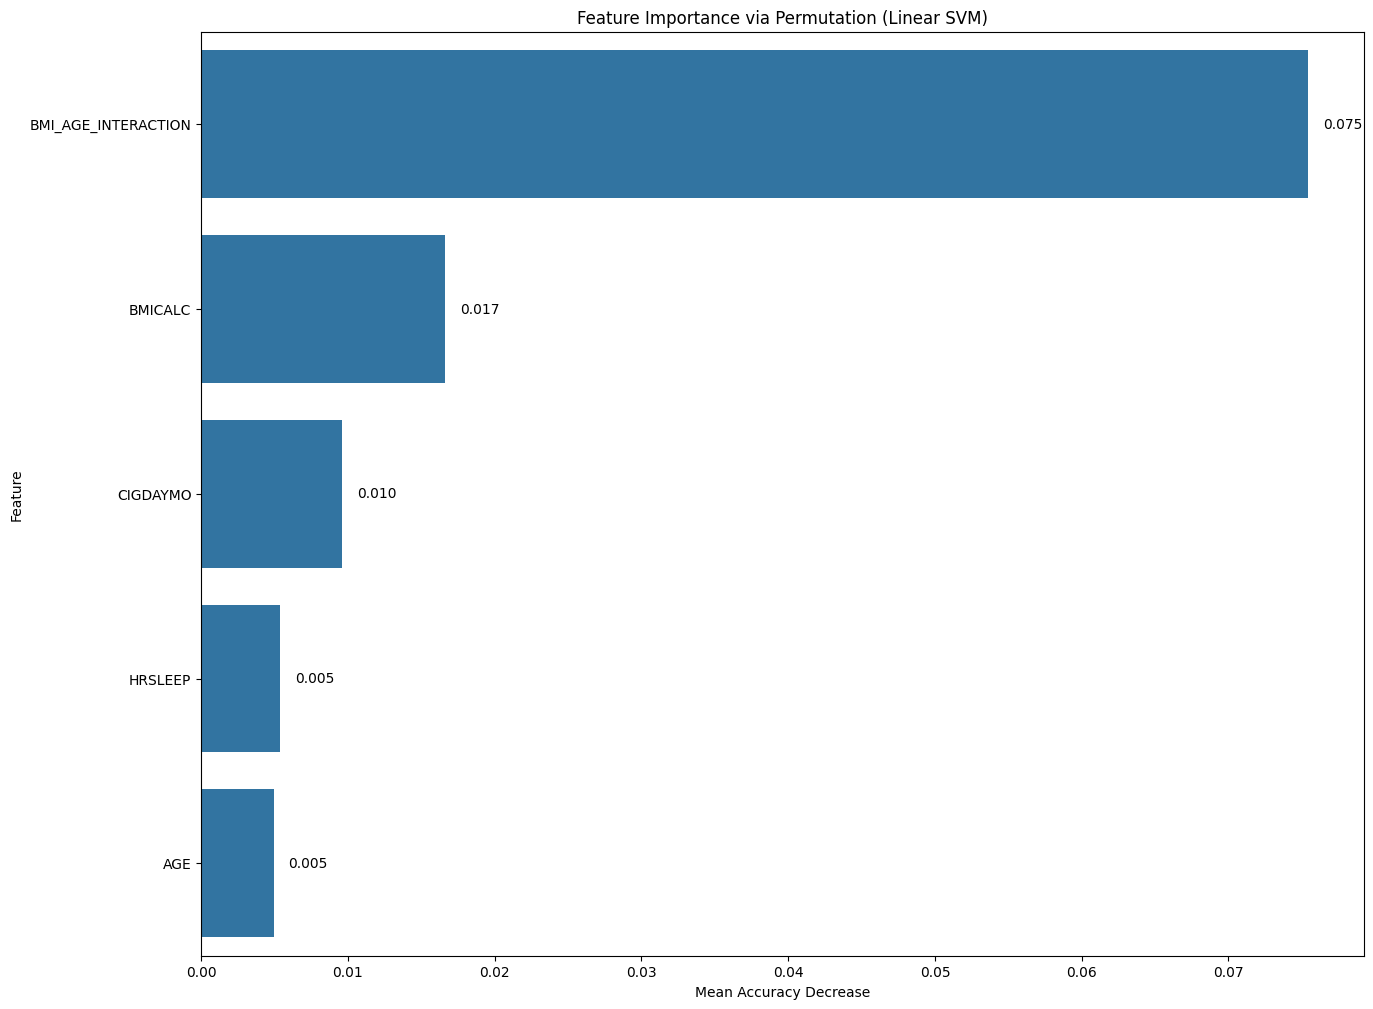

Key Findings:
Most Important Feature: BMI_AGE_INTERACTION
Least Important Feature: AGE


In [ ]:
# Cell 6: Feature Importance Analysis (with value labels)
from sklearn.inspection import permutation_importance

result = permutation_importance(
    svm_linear,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_names = features_with_interaction
importances = result.importances_mean
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(15, 12))
ax = sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance via Permutation (Linear SVM)')
plt.xlabel('Mean Accuracy Decrease')
plt.ylabel('Feature')


for bar in ax.patches:
    width = bar.get_width()
    plt.text(
        width + 0.001,  
        bar.get_y() + bar.get_height() / 2,
        f'{width:.3f}',
        va='center'
    )

plt.savefig("../results/linear_feature_importance.png")
plt.show()

print("Key Findings:")
print(f"Most Important Feature: {importance_df.iloc[0]['Feature']}")
print(f"Least Important Feature: {importance_df.iloc[-1]['Feature']}")


## Conclusion

The linear SVM model demonstrates several key findings for diabetes prediction:

### Model Performance
- Achieved 65% overall accuracy with an AUC of 0.77, indicating good discriminative ability
- **High recall (78%)** for diabetes cases - successfully identified 14 out of 18 diabetes cases
- Relatively low precision (18%) resulted in 64 false positives
- The model prioritizes sensitivity over specificity, making it well-suited for screening applications

### Feature Importance
- **BMI-Age interaction** emerged as the single most important predictor, demonstrating that the combination of these factors is more informative than either alone
- BMI was the second most important feature, consistent with clinical knowledge
- Smoking frequency (CIGDAYMO) showed moderate importance
- Interestingly, while Age itself had low importance individually, its interaction with BMI was critical

### Clinical Implications
- The linear decision boundary shows a clear risk gradient: as BMI increases, the age threshold for diabetes risk decreases
- The model's high recall makes it suitable for initial screening where missing cases is considered more costly than false positives
- For implementation in clinical settings, a threshold could be adjusted to balance recall and precision based on resource constraints

